In [5]:
def jobs_manager():
    from IPython.lib.backgroundjobs import BackgroundJobManager
    from IPython.core.magic import register_line_magic
    from IPython import get_ipython

    jobs = BackgroundJobManager()

    @register_line_magic
    def job(line):
        ip = get_ipython()
        jobs.new(line, ip.user_global_ns)

    return jobs

jobs = jobs_manager()

import argparse
from functools import partial
import itertools
from nile.api.v1 import(
    cli,
    datetime as dt,
    clusters,
    aggregators as na,
    filters as nf,
    extractors as ne,
    statface as ns,
    files as nfi,
    Record
)
from qb2.api.v1 import (
    filters as sf,
    extractors as se,
    resources as sr
)
import re
import requests
from statbox import mrtools
from statbox_bindings2.string_utils.simple_parsers import parse_request_params
from statbox.datetime.datetime_wrapper import datetime
from statutils.common.distribution.distribution_tree import(
    extract_mobile_distribution_tree_path
    )
from statutils.nile.report_diff import ReportDiff
import sys
from statutils.common.tools import get_path_prefixes

from itertools import (
    product,
    combinations,
    chain
)
import json

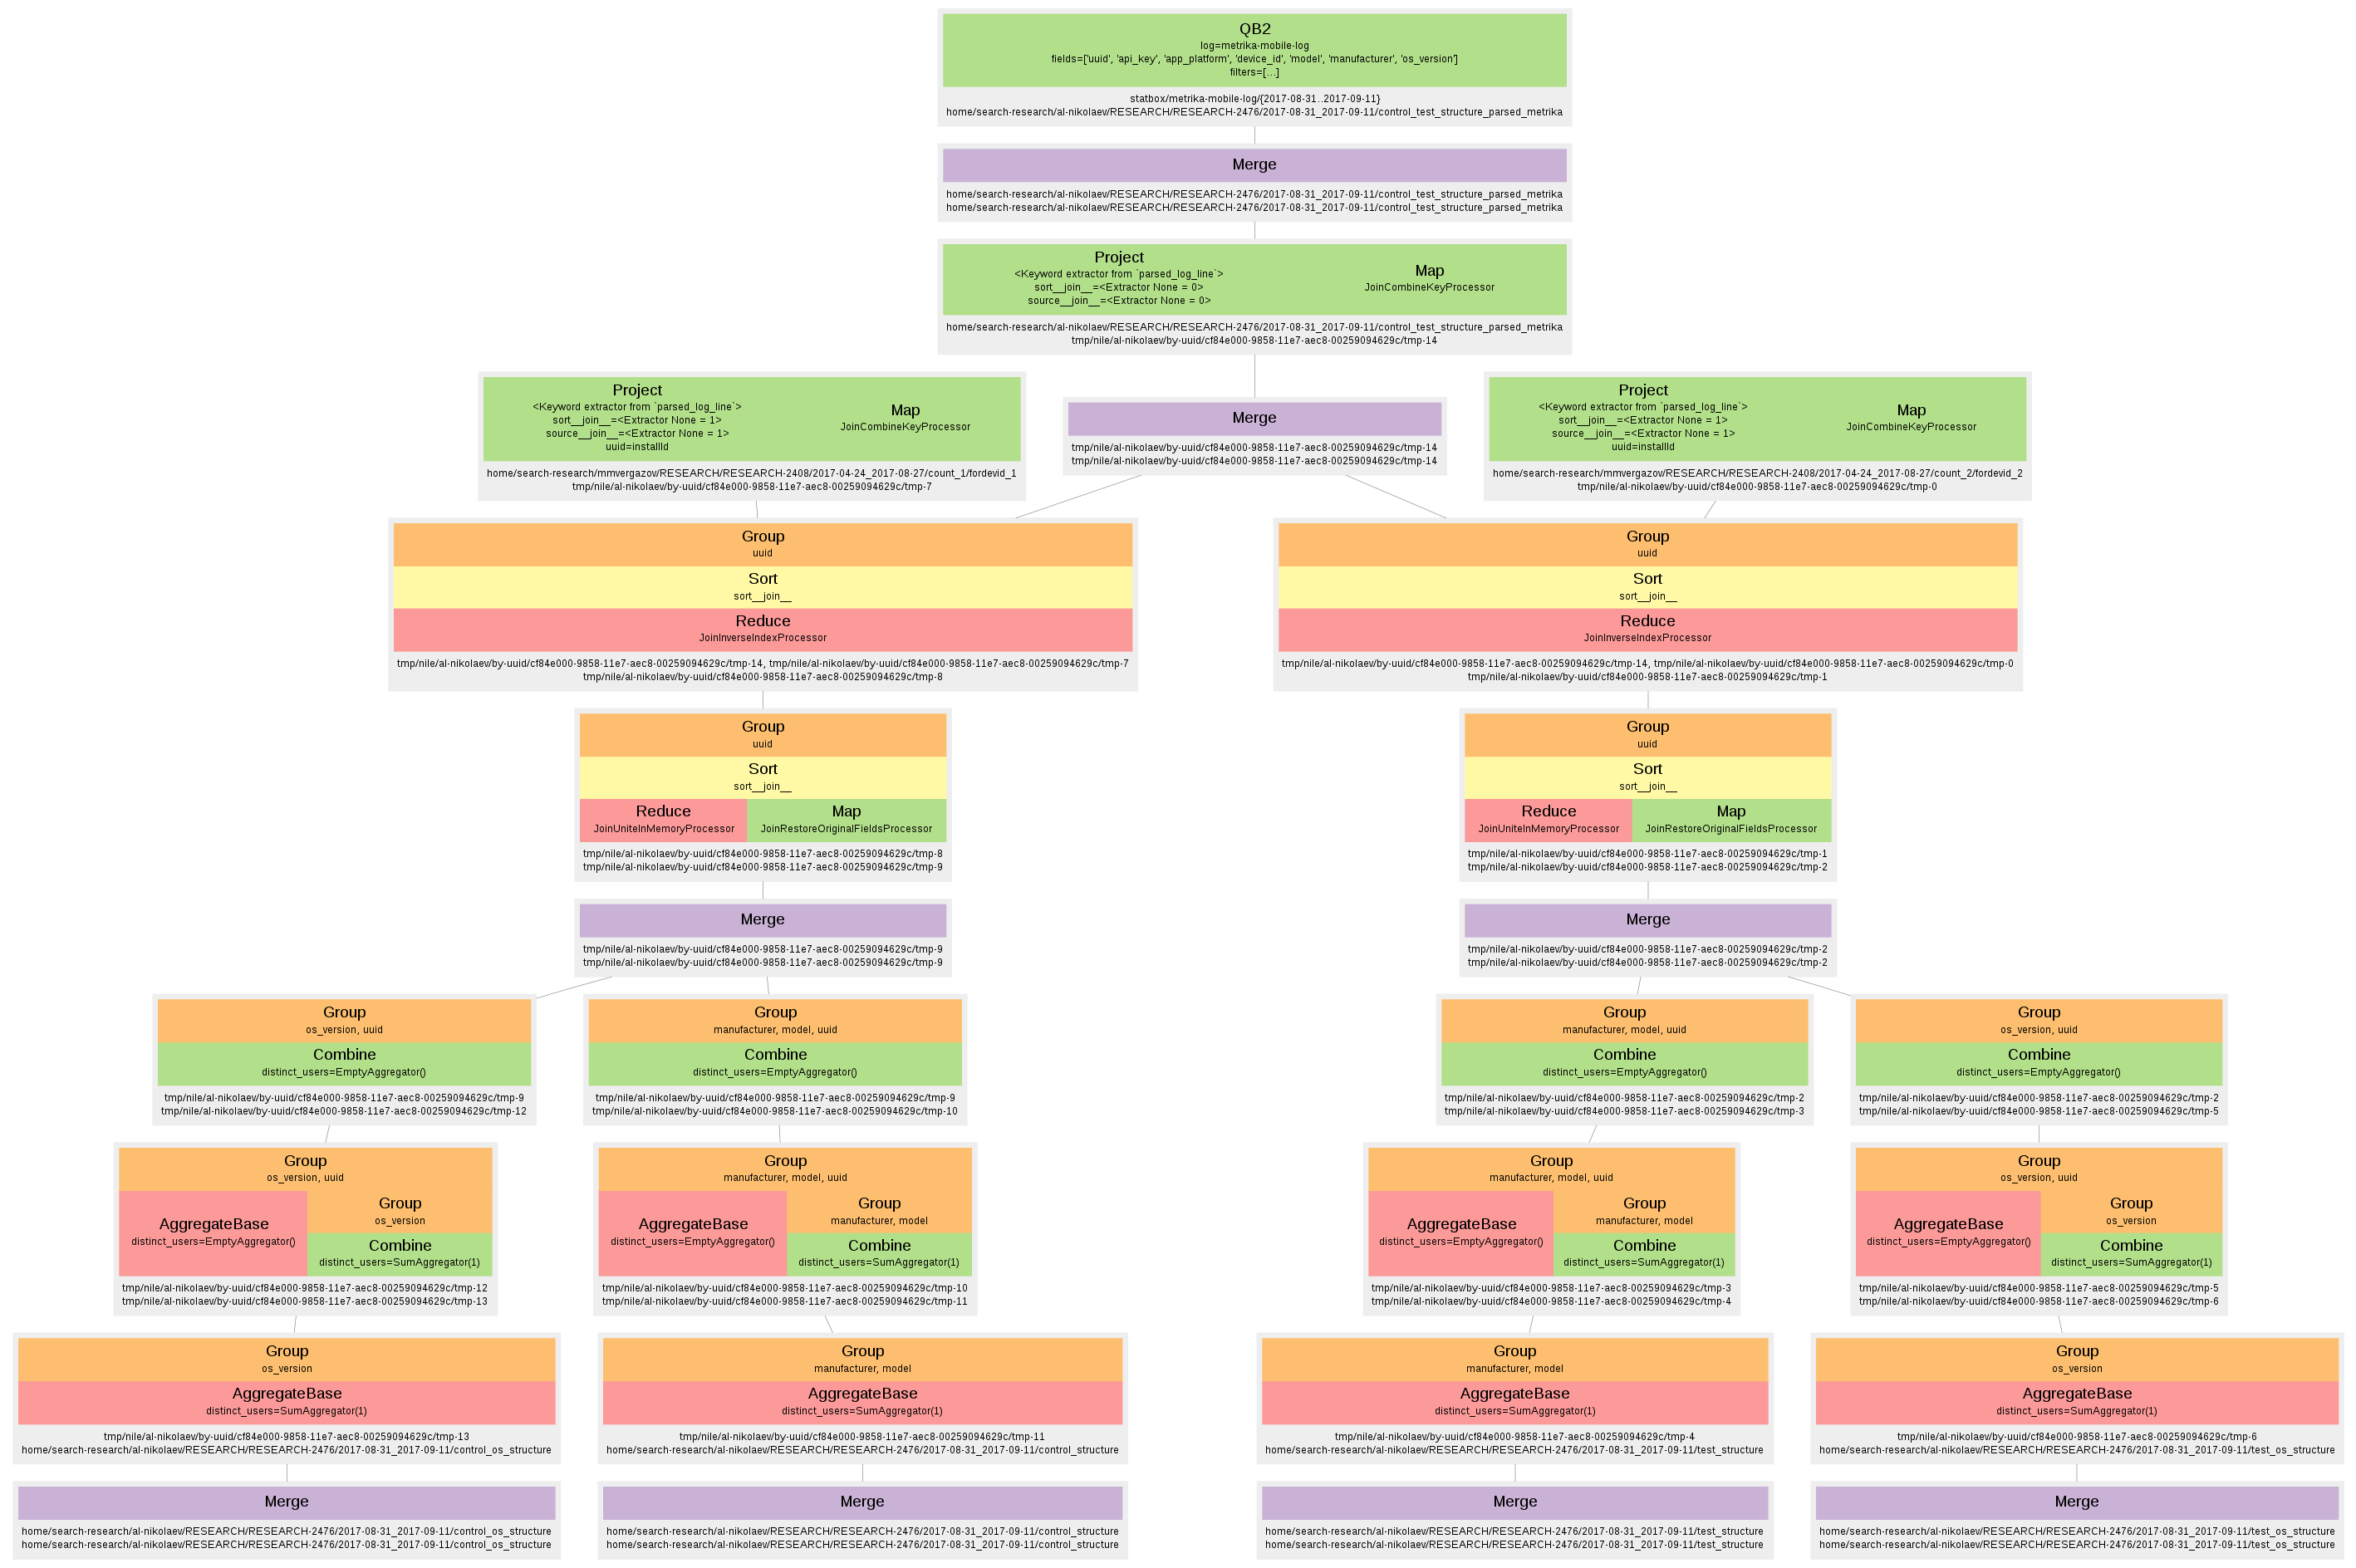

In [10]:
JOB_ROOT = 'home/search-research/al-nikolaev/RESEARCH/RESEARCH-2476'
METRIKA_MOBILE_LOG = 'statbox/metrika-mobile-log'
EMPTY = 'empty'
DATE = '2017-08-31_2017-09-11'

def get_model(parsed_log_line):
    model = EMPTY
    if 'Model' in parsed_log_line.keys():
        if parsed_log_line['Model']:
            model = parsed_log_line['Model']
    return model


def get_manufacturer(parsed_log_line):
    manufacturer = EMPTY
    if 'Manufacturer' in parsed_log_line.keys():
        if parsed_log_line['Manufacturer']:
            manufacturer = parsed_log_line['Manufacturer']
    return manufacturer

def get_os_version(parsed_log_line):
    os_version = EMPTY
    if 'OSVersion' in parsed_log_line.keys():
        if parsed_log_line['OSVersion']:
            os_version = parsed_log_line['OSVersion']
    return os_version

cluster = clusters.Hahn().env(
        templates=dict(
            job_root=JOB_ROOT,
            dates='{2017-08-31..2017-09-11}'
        )
    )

job = cluster.job()

metrika = job.table(METRIKA_MOBILE_LOG + '/' + '@dates')
parsed_metrika = metrika.qb2(
    log='metrika-mobile-log',
    fields=[
        'uuid',
        'api_key',
        'app_platform',
        'device_id',
        se.custom(
            'model',
            get_model,
            'parsed_log_line'
        ),
        se.custom(
            'manufacturer',
            get_manufacturer,
            'parsed_log_line'
        ),
        se.custom(
            'os_version',
            get_os_version,
            'parsed_log_line'
        )
    ],
    filters=[
        sf.equals('api_key', 10321)
    ]
).put(
    '$job_root/{}/control_test_structure_parsed_metrika'.format(DATE)
)

control = job.table('home/search-research/mmvergazov/RESEARCH/RESEARCH-2408/2017-04-24_2017-08-27/count_1/fordevid_1')
test = job.table('home/search-research/mmvergazov/RESEARCH/RESEARCH-2408/2017-04-24_2017-08-27/count_2/fordevid_2')

control_data = parsed_metrika.join(control, by_left='uuid', by_right='installId', type='inner')
test_data = parsed_metrika.join(test, by_left='uuid', by_right='installId', type='inner')

control_structure = control_data.groupby('manufacturer', 'model').aggregate(distinct_users=na.count_distinct('uuid')).put('$job_root/{}/control_structure'.format(DATE))
test_structure = test_data.groupby('manufacturer', 'model').aggregate(distinct_users=na.count_distinct('uuid')).put('$job_root/{}/test_structure'.format(DATE))

control_os_structure = control_data.groupby('os_version').aggregate(distinct_users=na.count_distinct('uuid')).put('$job_root/{}/control_os_structure'.format(DATE))
test_os_structure = test_data.groupby('os_version').aggregate(distinct_users=na.count_distinct('uuid')).put('$job_root/{}/test_os_structure'.format(DATE))

job.commands_graph

In [ ]:
job.run()